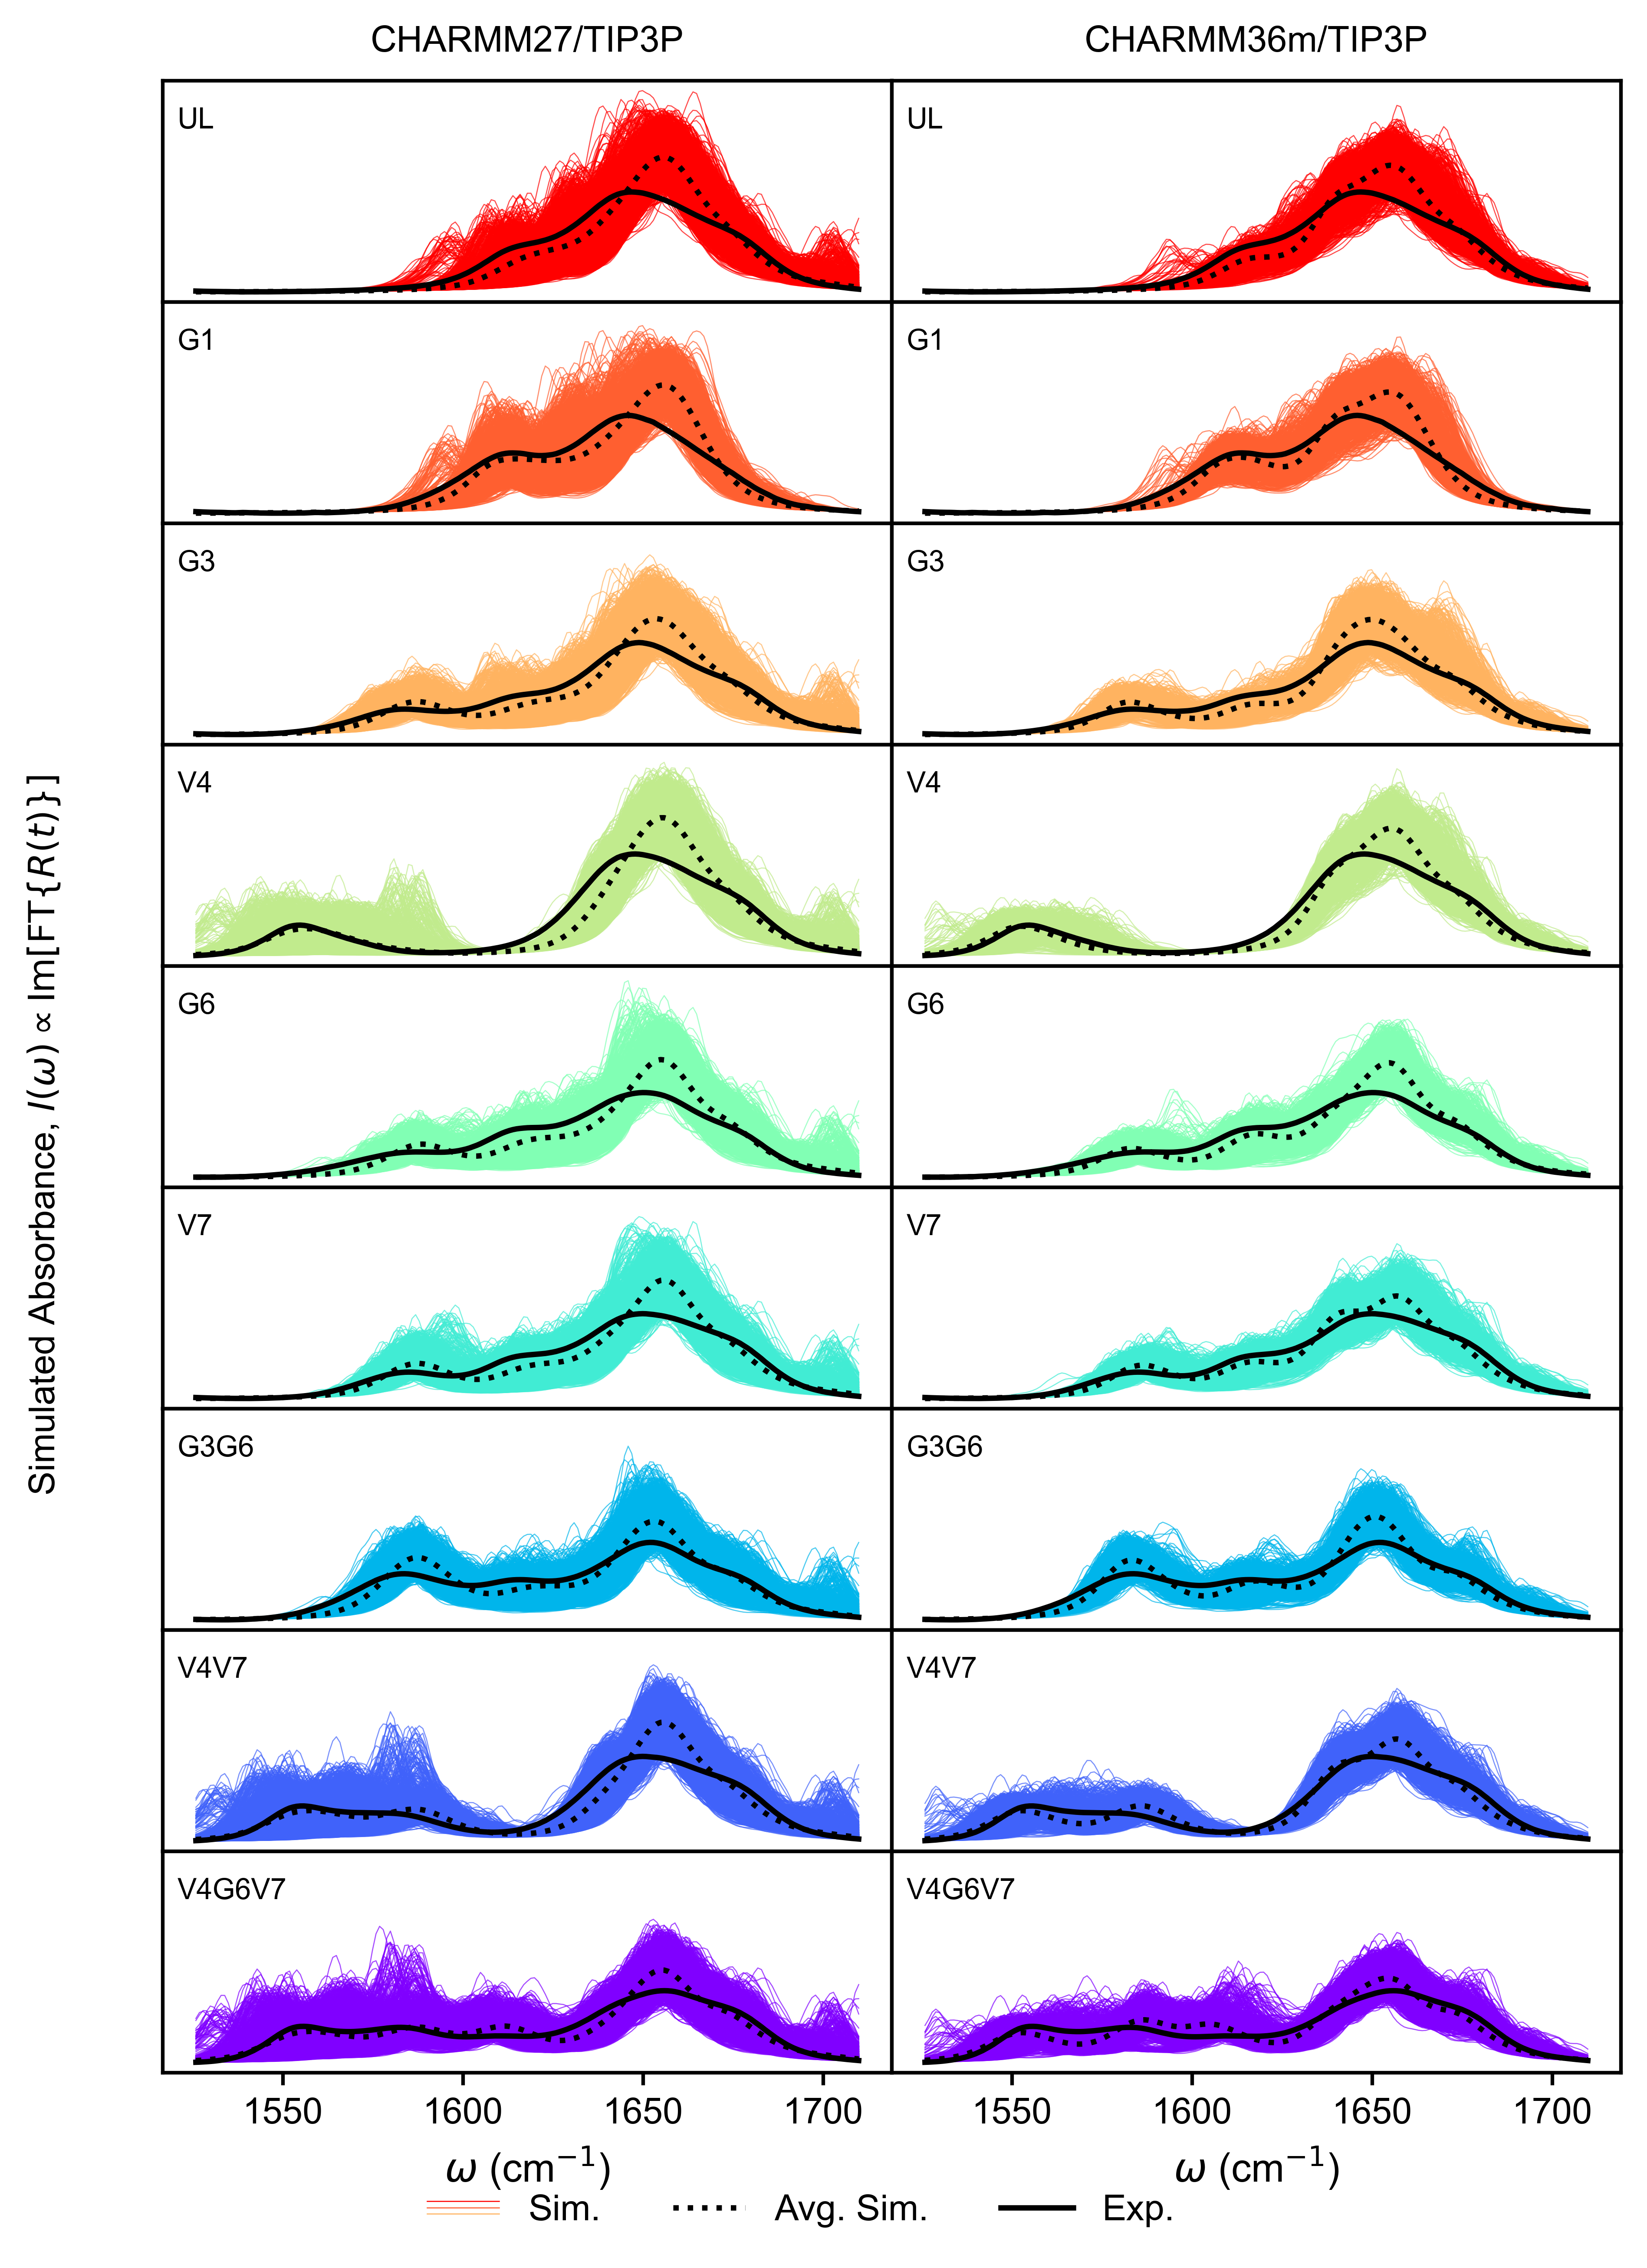

In [1]:
### PLOTS ALL SPECTRAL ENSEMBLES FOR 500 ns TRAJECTORY FOR BOTH FFs (FIG S02) ###
### 2 Aug 2025 ###

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.legend_handler import HandlerBase

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------

# Paths
BASE_DIR = Path('../data')
EXP_DIR = BASE_DIR / 'exp_data' / 'processed_FTIRs'
SIM_DIR = BASE_DIR / 'sim_data' / 'sim_spec'
WAVENUMBERS_FILE = BASE_DIR / 'waxis.txt'

# Data Specifications
ISOTOPES = ['WT', 'G3+', 'G5+', 'V1', 'G3', 'V4', 'G5+G3', 'V1V4', 'V1G3V4']
FORCE_FIELDS = ['CHARMM27_TIP3P', 'CHARMM36m_TIP3P']
MAP_TYPE = 'DC1Fnew'

ISOTOPE_LABELS = {
    'WT': 'UL', 'G3+': 'G1', 'G5+': 'G3', 'V1': 'V4', 'G3': 'G6', 
    'V4': 'V7', 'G5+G3': 'G3G6', 'V1V4': 'V4V7', 'V1G3V4': 'V4G6V7'
}

ISOTOPE_FILE_MAP = {
    'WT': 'GVGn1_WT_50mgmL_phos_150mM_pH1_basecorr_processed.npy',
    'G3+': 'GVGn1_G3dag_50mgmL_phos_150mM_pH1_basecorr_processed.npy',
    'G5+': 'GVGn1_G5dag_50mgmL_phos_150mM_pH1_basecorr_processed.npy',
    'V1': 'GVGn1_V1_50mgmL_phos_150mM_pH1_basecorr_processed.npy',
    'G3': 'GVGn1_G3_50mgmL_phos_150mM_pH1_basecorr_processed.npy',
    'V4': 'GVGn1_V4_50mgmL_phos_150mM_pH1_basecorr_processed.npy',
    'G5+G3': 'GVGn1_G5dagG3_50mgmL_phos_150mM_pH1_basecorr_processed.npy',
    'V1V4': 'GVGn1_V1V4_50mgmL_phos_150mM_pH1_basecorr_processed.npy',
    'V1G3V4': 'GVGn1_V1G3V4_50mgmL_phos_150mM_pH1_basecorr_processed.npy'
}

# Analysis Parameters
FULL_RANGE = (1525, 1750)
PLOT_RANGE = (1525, 1710)

# Plotting Specifications
FIGURE_SIZE = (7, 9)
DPI = 300

# -----------------------------------------------------------------------------
# DATA LOADING
# -----------------------------------------------------------------------------

def load_wavenumbers(wavenumber_min, wavenumber_max):
    """Load wavenumbers within specified range."""
    wavenumbers = np.loadtxt(WAVENUMBERS_FILE)
    mask = (wavenumbers >= wavenumber_min) & (wavenumbers <= wavenumber_max)
    return wavenumbers[mask]

def load_experimental_spectrum(isotope, wavenumbers_full, wavenumbers_plot):
    """Load and normalize experimental spectrum."""
    filepath = EXP_DIR / ISOTOPE_FILE_MAP[isotope]
    spectrum = np.load(filepath)
    normalized = spectrum / np.trapz(spectrum, x=wavenumbers_full)
    return restrict_to_plot_range(normalized, wavenumbers_full, wavenumbers_plot)

def load_simulation_spectra(isotope, force_field, wavenumbers_full, wavenumbers_plot):
    """Load and normalize all simulation spectra for given isotope and force field."""
    filename = f'{MAP_TYPE}_{force_field}_{isotope}_ftir.npy'
    filepath = SIM_DIR / force_field / filename
    
    raw_spectra = np.load(filepath)
    corrected_spectra = raw_spectra - np.min(raw_spectra, axis=1)[:, np.newaxis]
    normalized_spectra = corrected_spectra / np.trapz(corrected_spectra, x=wavenumbers_full, axis=1)[:, np.newaxis]
    
    # Restrict to plot range
    plot_spectra = restrict_to_plot_range(normalized_spectra, wavenumbers_full, wavenumbers_plot)
    average_spectrum = np.mean(plot_spectra, axis=0)
    
    return plot_spectra, average_spectrum

# -----------------------------------------------------------------------------
# ANALYSIS
# -----------------------------------------------------------------------------

def restrict_to_plot_range(data, wavenumbers_full, wavenumbers_plot):
    """Restrict data to 1710 cm^-1."""
    mask = np.isin(wavenumbers_full, wavenumbers_plot)
    if data.ndim == 1:
        return data[mask]
    return data[:, mask]

# -----------------------------------------------------------------------------
# CUSTOM LEGEND HANDLER, FOR VISUAL PURPOSES
# -----------------------------------------------------------------------------

class MultiColorLine:
    """Custom object for multi-colored line in legend."""
    def __init__(self, colors, linewidth):
        self.colors = colors
        self.linewidth = linewidth

class MultiColorLineHandler(HandlerBase):
    """Custom handler for multi-colored line legend entry."""
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        y_positions = [height * 0.75, height * 0.5, height * 0.25]
        lines = []
        for y_pos, color in zip(y_positions, orig_handle.colors[:3]):
            line = plt.Line2D([xdescent, xdescent + width], 
                            [ydescent + y_pos, ydescent + y_pos], 
                            color=color, 
                            linewidth=orig_handle.linewidth, 
                            transform=trans)
            lines.append(line)
        return lines

# -----------------------------------------------------------------------------
# PLOTTING
# -----------------------------------------------------------------------------

def set_plot_style():
    """Set consistent plot style for ACS publication figures."""
    plt.rcParams.update({
        # Font settings - Arial (PC) or Helvetica (Mac) as per ACS
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],
        'font.size': 10,  # Will be readable at 5pt when reduced to column width
        
        # Line widths - minimum 1 pt as per ACS
        'lines.linewidth': 1.0,
        'axes.linewidth': 1.0,
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.minor.width': 1.0,
        'ytick.minor.width': 1.0,
        'patch.linewidth': 1.0,
        'grid.linewidth': 1.0,
        
        # Font sizes - accounting for reduction
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        
        # DPI settings
        'figure.dpi': 600
    })

def plot_single_panel(ax, isotope, force_field, color, wavenumbers_full, wavenumbers_plot):
    """Plot single comparison panel for isotope and force field."""
    # Obtains spectral ensemble and average simulated spectrum
    # Load data
    experimental_spectrum = load_experimental_spectrum(isotope, wavenumbers_full, wavenumbers_plot)
    simulation_spectra, average_simulation = load_simulation_spectra(
        isotope, force_field, wavenumbers_full, wavenumbers_plot
    )
    
    # Plot individual simulations
    for spectrum in simulation_spectra:
        ax.plot(wavenumbers_plot, spectrum, color=color, linewidth=0.3, alpha=0.7)
    
    # Plot experimental and average simulation
    ax.plot(wavenumbers_plot, experimental_spectrum, color='black', linewidth=1.5)
    ax.plot(wavenumbers_plot, average_simulation, color='black', linewidth=1.5, linestyle=':')
    
    # Add isotope label
    ax.text(0.02, 0.88, ISOTOPE_LABELS[isotope], 
            transform=ax.transAxes, fontsize=8, ha='left', va='top',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=1))
    
    # Remove y-axis ticks
    ax.set_yticks([])

def add_figure_annotations(fig, axes):
    """Add titles, labels, and legend to figure."""
    # Add column titles
    axes[0, 0].set_title('CHARMM27/TIP3P', fontsize=10, pad=8)
    axes[0, 1].set_title('CHARMM36m/TIP3P', fontsize=10, pad=8)
    
    # Format x-axis labels
    for i in range(len(ISOTOPES)):
        for j in range(2):
            if i < len(ISOTOPES) - 1:
                axes[i, j].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            else:
                axes[i, j].set_xlabel(r'$\omega$ (cm$^{-1}$)')
    
    # Add y-axis label
    fig.text(0.075, 0.5, 
             'Simulated Absorbance, $I(\omega) \propto \mathrm{Im}[\mathrm{FT}\{R(t)\}]$',
             va='center', rotation='vertical', fontsize=10)
    
    # Create legend
    colors = plt.cm.rainbow(np.linspace(0, 1, len(ISOTOPES)))[::-1]
    legend_handles = [
        MultiColorLine(colors, 0.3),
        plt.Line2D([0], [0], color='black', linestyle=':', linewidth=1.5),
        plt.Line2D([0], [0], color='black', linewidth=1.5)
    ]
    legend_labels = ['Sim.', 'Avg. Sim.', 'Exp.']
    
    fig.legend(handles=legend_handles, labels=legend_labels,
               loc='lower center', bbox_to_anchor=(0.5, 0.02),
               ncol=3, frameon=False, 
               handler_map={MultiColorLine: MultiColorLineHandler()})

# -----------------------------------------------------------------------------
# MAIN
# -----------------------------------------------------------------------------

def main():
    """Main function to generate figure."""
    set_plot_style()
    
    # Load wavenumber axes
    wavenumbers_full = load_wavenumbers(*FULL_RANGE)
    wavenumbers_plot = load_wavenumbers(*PLOT_RANGE)
    
    # Generate colors for isotopes
    colors = plt.cm.rainbow(np.linspace(0, 1, len(ISOTOPES)))[::-1]
    
    # Create figure
    fig, axes = plt.subplots(len(ISOTOPES), 2, figsize=FIGURE_SIZE, 
                            sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0, hspace=0, left=0.15, bottom=0.1, 
                       right=0.95, top=0.95)
    
    # Plot each isotope-force field combination
    for i, isotope in enumerate(ISOTOPES):
        for j, force_field in enumerate(FORCE_FIELDS):
            plot_single_panel(axes[i, j], isotope, force_field, colors[i], 
                            wavenumbers_full, wavenumbers_plot)
    
    # Add annotations and formatting
    add_figure_annotations(fig, axes)
    
    plt.show()

if __name__ == "__main__":
    main()